How to stay on top: exploring  transfer policies and  player develpoment of the Bundesliga's most dominant teams

Project Proposal


#  Aims, objectives and background

## Introduction

Since the 2009/2010 season FC Bayern Munich (FCB) has won the German Bundesliga an astounding amount of ten times, only losing out to Borussia Dortmund (BVB) in the seasons 10/11 and 11/12.
And even in the seasons, Munich did not win, they managed to stay in the top 3 with a final league standing of third and second in the seasons 10/11 and 11/12 respectively[1].

Since 2009 Dortmund only won the Bundesliga two times but get second in the final league standings 6 times.
Staying on top for this long is a remarkable achievement by both organizations and teams. Because those two teams have been dominant this long, they must be doing something right in regards to player development and their approach to transfers. Otherwise, they would not be able to field consistently winning teams for over a decade. 

There are several factors at play as to why a soccer team performs well and as to how a club is managed well. I wanted to explore the idea of using statistical analysis and data science techniques to compare and create metrics and to gain insights into how to stay on top of a league this long. In my opinion, it is especially interesting to compare those two clubs and their approaches and if their approaches changed over the years.


## Aims and Objectives

Within this project I would like to explore the following:
-	How do FCB and BVB approach their transfer strategy? Are they buying well-known superstars for a lot of money or are they 
    taking their chances with cheaper rookies?
-	Has their approach changes over the years or e.g., after not winning the league?
-	How well is their transfer strategy panning out? Do newly bought players perform well immediately or are they flopping?
-	How well are both teams developing their players? Are the players getting better/worse?
-	Do they promote a lot of young players from their second division? Are those players getting enough time to adapt?
-	How long are new transfers staying on the team? Do they become key players?
-	Do the two teams buy/sell their players below/above market value?
-	Are both teams consistently fielding their best starting squad? Or are they having problems with injuries?

There are more questions to be answered, but in general, the project should answer the questions above and gain insight into the transfer policy and player development of both teams, to get an idea behind the reasons for their dominance.

For this project proposal, my aims are to:
1.	Decide what and how much data is required to sufficiently explore the above questions, taking into consideration constraints on time and resource
2.	Collect the data via web scraping and store it in a form that allows for data cleaning and analysis
3.	Clean and transform the data such that it is suitable for use in the techniques I would like to utilize later
4.	Carry out some exploratory data analysis to identify that there are trends within the data that make it viable for further exploration


# Data

## Source and ethics of the use of data 


I decided to use the transfer history of both teams for each season since the season of 2009/2010.
In addition, the squad details of each season will be used as data for both teams. This data includes metrics for each player like: “in the squad”, “goals”, “yellow cards” etc.
All of the data will be scraped from transfermarkt.co.uk, which is a website that mostly tracks transfers and transfer rumors but also has the above-mentioned data available.

Transfermarkt was chosen as a source because it has data on transfers and player statistics and having the same source website was beneficial for the process of web scraping.
Transfermarkt has no clause forbidding web scraping in their terms and conditions. In addition, I checked the robots.txt of each website to ensure there was no Disallow clause on the sections of the websites I wanted to scrape. All data is in the public sphere, so no anonymization of data is required.

Furthermore, I concluded that summaries produced by this project, will not create any dangerous or harmful assumptions. This project will compare the statistics of players and draw conclusions from those statistics and evaluate them. In this process, there could be the conclusion that a player has not performed well throughout the season. But that conclusion will not be subjective but based on comparisons to e.g., average goals scored (when evaluating the performance of a striker/forward). Players from top teams are constantly evaluated and judged by the public, so there will not be any harm done if this project concludes that their performance was bad or similar.



## Requirements and limitations of the data


Scraping the full transfer history and basic player statistics from Transfermarkt should be enough to answer most of the questions and objectives. However, it is difficult/problematic to evaluate a player, solely on basic statistics.
For example, is Manuel Neuer worse than another goalkeeper just because he has fewer shots saved in a match? Neuer probably just had to save way less in the first place, since his team and the defense are so good, not allowing many shots on his goa to happen. So, judging a player’s performance based on statistics will be difficult. 

To tackle this problem, the approaches of others who faced the same challenge will be investigated. Unfortunately, evaluating players on statistics is a valuable skill and most of the knowledge on how to do it properly is behind paywalls, accessing that knowledge by paying a large amount of money was not an option for this project proposal. 

The scraped data about player statistics will be very basic and it won’t be easy to properly evaluate performance only with this data. In the main project (CW2), I might use another dataset from Kaggle (Soccer players values and their statistics | Kaggle) to add more depth for player statistics. This dataset uses data from Tansfermarkt and FBref. The latter one is a website about soccer player statistics, which I wanted to scrape in the first place. Unfortunately, their terms and usage do not allow any kind of scraping and they ask for a fee of 1000€ to use their data, which is unfeasible for me/this project.

If the originally scraped data is not sufficient enough to gain enough insights, I can simply search for other sources to be web scraped as part of the CW2.  It was not possible to web scrape several player statistics data websites beforehand for this project proposal due to time and resource constraints. 

# Implementation


In [1]:
# Importing libraries
from lxml import etree
from urllib import request
import pandas as pd
import re
import matplotlib.pyplot as plt


# Show all matplotlib graphs inline
%matplotlib inline

## Webscraping: defining functions

Prior to scraping the content of the different URLs, we need to define several functions which we can call to scrape
the data. 

The functions return the extracted information in the form of a pandas DataFrame.

Scraping can take a minute or two!

In [2]:
# function to request an HTML page from www.transfermarkt.co.uk
def request_page(url):
    # source: https://github.com/RSKriegs/Modelling-Football-Players-Values-on-Transfer-Market-and-Their-Determinants-using-Robust-Regression
    # /blob/main/scrapers/transfermarkt-scraping-master/transfermarkt-scraping-master/main.py
    opener = request.build_opener()
    # set Mozilla/5.0 as User-agent in order to receive a response from the webserver
    # the site's robots.txt requires a user-agent to be set
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    # request the page
    response = opener.open(url)
    # use lxml's HTML parser
    htmlparser = etree.HTMLParser()
    # parse the document in order to obtain a tree of nodes
    tree = etree.parse(response, htmlparser)
    return tree

In [3]:
# function to parse the HTML page containing the transfers of the specified club
# direction defines the type of the club's transfers (i.e. "in" or "out)
def read_transfers_table(tree, *, club, direction):
    # parse direction parameter
    direction = direction.lower()
    if direction == "in":
        # the "in" transfers are in table number 1
        table_number = 1
    elif direction == "out":
        # the "out" transfers are in table number 2
        table_number = 2
    else:
        # only allow those two directions; otherwise throw an error
        raise ValueError("Invalid direction: " + direction)

    # XPath to the rows inside the table containing the club's transfers
    rows = tree.xpath('//div[div/a/@title="{club}"]/div[@class="responsive-table"][{table_number}]//tbody/tr'
                      .format(club=club, table_number=table_number))
    data = []
    # extract the information for each table row
    for r in rows:
        name = r.xpath('td[1]/div/span[@class="hide-for-small"]/a/@title')[0]
        age = r.xpath('td[2]/text()')[0]
        # nat = r.xpath('td[3]/text()')[0]
        position = r.xpath('td[4]/text()')[0]
        market_value = r.xpath('td[6]/text()')[0]
        # in some cases, there is no hyperlink element
        # instead, the data is stored directly as text in the parent element
        if len(r.xpath('td[8]/a')):
            # extract the data from the link element if the hyperlink element exists
            left_joined = r.xpath('td[8]/a/text()')[0].strip()
        else:
            # otherwise, extract the data directly from the text of the parent element
            left_joined = r.xpath('td[8]/text()')[0].strip()
        fee = r.xpath('td[9]/a/text()')[0]
        # add the information extracted from the row to the data list
        data.append([club, direction, name, age, position, market_value, left_joined, fee])

    # create a DataFrame from the raw data
    return pd.DataFrame(data=data, columns=["club", "direction", "name", "age", "position", "market_value",
                                            "left_joined", "fee"])

In [4]:
# function to request the transfers page of a single season
def scrape_transfers_page(*, season):
    # build the correct URL for the corresponding season
    url = transfers_base_url.format(season=season)

    # request the page and parse it
    tree = request_page(url)

    # DataFrame to contain the data of all specified clubs in the specified season
    df = pd.DataFrame()
    for club in clubs:
        # read the in transfers table
        in_transfers_data = read_transfers_table(tree, club=club, direction="in")
        # set the season in the season column
        in_transfers_data["season"] = season

        # read the out transfers table
        out_transfers_data = read_transfers_table(tree, club=club, direction="out")
        # set the season in the season column
        out_transfers_data["season"] = season

        # add the in and out transfers of the current club to the DataFrame containing all data for the season
        df = pd.concat([df, in_transfers_data, out_transfers_data], ignore_index=True)

    return df

In [5]:
# function scraping the transfer data and returning a DataFrame
def scrape_transfers():
    # DataFrame to contain the data of all specified seasons
    df = pd.DataFrame()
    for year in seasons:
        # scrape the transfer data for the current season
        season_data = scrape_transfers_page(season=year)
        # add the transfers of the current season to the DataFrame containing the data of all seasons
        df = pd.concat([df, season_data], ignore_index=True)
    return df

In [6]:
#function  reading player table and returninga DataFrame
def read_players_table(tree, *, club):
    # XPath to the rows inside the table containing the statistics of the club's players
    rows = tree.xpath('//*[@id="yw1"]/table/tbody/tr')
    data = []
    # extract the information for each table row
    for r in rows:
        name = r.xpath('td[2]//tr[1]/td[@class="hauptlink"]//span[@class="hide-for-small"]/a/text()')[0]
        position = r.xpath('td[2]//tr[2]/td/text()')[0]
        age = r.xpath('td[3]/text()')[0]
        # nat = r.xpath('td[4]/text()')[0]
        in_squad = r.xpath('td[5]/text()')[0]
        # in some cases, the appearances table disk spans multiple columns and is used for additional information
        # about the player
        if int(r.xpath('td[6]/@colspan')[0]) > 1:
            # if the colspan attribute is greater than 1, than the element spans multiple columns
            # in this case, appearances is set to "-" and the element's text is additional information
            appearances = "-"
            info = r.xpath('td[6]/text()')[0]
        else:
            # else, the element's text is the number of appearances and there is no additional information
            appearances = r.xpath('td[6]/text()')[0]
            info = "-"
        goals = r.xpath('td[7]/text()')[0]
        assists = r.xpath('td[8]/text()')[0]
        yellow_cars = r.xpath('td[9]/text()')[0]
        second_yellow_cards = r.xpath('td[10]/text()')[0]
        red_cards = r.xpath('td[11]/text()')[0]
        substitutions_on = r.xpath('td[12]/text()')[0]
        substitutions_off = r.xpath('td[13]/text()')[0]
        ppg = r.xpath('td[14]/text()')[0]
        minutes_played = r.xpath('td[15]/text()')[0]

        # add the information extracted from the row to the data list
        data.append([club, name, age, position, in_squad, appearances, goals, assists, yellow_cars, second_yellow_cards,
                     red_cards, substitutions_on, substitutions_off, ppg, minutes_played, info])

    # create a DataFrame from the raw data
    return pd.DataFrame(data=data, columns=["club", "name", "age", "position", "in_squad", "appearances", "goals",
                                            "assists", "yellow_cards", "second_yellow_cards", "red_cards",
                                            "substitutions_on", "substitutions_off", "ppg", "minutes_played", "info"])


In [7]:
# function to request the player statistics page of a single season
def scrape_players_page(*, base_url, season):
    # build the correct URL for the corresponding season
    url = base_url.format(season=season)

    # request the page and parse it
    tree = request_page(url)

    # DataFrame to contain the data of all specified clubs in the specified season
    df = pd.DataFrame()
    for club in clubs:
        # read the player statistics table
        players_data = read_players_table(tree, club=club)
        # set the season in the season column
        players_data["season"] = season

        # add the player statistics of the current club to the DataFrame containing all data for the season
        df = pd.concat([df, players_data], ignore_index=True)

    return df


In [8]:
# function scraping the player statistics data and returning a DataFrame
def scrape_players():
    # DataFrame to contain the data of all specified seasons
    df = pd.DataFrame()
    for year in seasons:
        for base_url in players_base_urls:
            # scrape the player statistics data for the current season
            season_players_data = scrape_players_page(season=year, base_url=base_url)
            # add the player statistics of the current season to the DataFrame containing the data of all seasons
            df = pd.concat([df, season_players_data], ignore_index=True)
    return df


## Webscraping: extracting information

First the transfer history of the clubs will be scraped.

The Season column will be named after the  Year in which season started. e.g. 2010 = season 2010/2011.

In [9]:
# scrape transfer histroy

# range of seasons to scrape
seasons = range(2010, 2021)

# list of clubs to scrape
clubs = ["Bayern Munich", "Borussia Dortmund"]

# URL to retrieve transfers from
transfers_base_url = "https://www.transfermarkt.co.uk/bundesliga/transfers/wettbewerb/L1/plus/?saison_id={season}&s_w=&leihe=1&intern=0&intern=1"

# get a DataFrame containing the transfers by scraping www.transfermarkt.co.uk
transfers = scrape_transfers()
transfers.to_csv("transfers.csv", index=False)



Now, scrape player statistics of the two clubs, for each season.

In [10]:
# scrape player statistics

# range of seasons to scrape
seasons = range(2010, 2021)

# list of URLs of the clubs to scrape
players_base_urls = [
    "https://www.transfermarkt.co.uk/bayern-munich/leistungsdaten/verein/27/plus/1?reldata=%26{season}",
    "https://www.transfermarkt.co.uk/borussia-dortmund/leistungsdaten/verein/16/plus/1?reldata=%26{season}"
]

players = scrape_players()
players.to_csv("players.csv", index=False)

## Webscraping: check results

The scraping is done and the data is stored in two different pandas DataFrames.

Both dataframes have also been saved as a csv file.

The dataframes and csv files are called: 1.transfers and 2.players.

I did not scrape every detail of the tables that contained the information on the scraped websites. 
Instead, only the relevant columns have been scraped. E.g. the transfers df has a left_joined columns which on the scaped website were 2 different columns left and joined.

Below the dataframes are displayed and some error checking will be done to make sure, everything was scraped as intended.

In [11]:
display(transfers)

,club,direction,name,age,position,market_value,left_joined,fee,season
0,Bayern Munich,in,Luiz Gustavo,23,Defensive Midfield,£3.24m,TSG Hoffenheim,£15.30m,2010
1,Bayern Munich,in,David Alaba,18,Centre-Back,£49.50m,FC Bayern II,-,2010
2,Bayern Munich,in,Toni Kroos,20,Central Midfield,£22.50m,Bay. Leverkusen,End of loan,2010
3,Bayern Munich,in,Edson Braafheid,27,Left-Back,£90Th.,Celtic,End of loan,2010
4,Bayern Munich,in,Andreas Ottl,25,Defensive Midfield,-,1.FC Nuremberg,End of loan,2010
...,...,...,...,...,...,...,...,...,...
465,Borussia Dortmund,out,Marius Wolf,25,Right Winger,£4.50m,1. FC Köln,loan transfer,2020
466,Borussia Dortmund,out,Immanuel Pherai,19,Attacking Midfield,£630Th.,PEC Zwolle,loan transfer,2020
467,Borussia Dortmund,out,André Schürrle,29,Left Winger,-,Retired,-,2020
468,Borussia Dortmund,out,Achraf Hakimi,21,Right-Back,£63.00m,Real Madrid,End of loan,2020


In [12]:
display(players)

,club,name,age,position,in_squad,appearances,goals,assists,yellow_cards,second_yellow_cards,red_cards,substitutions_on,substitutions_off,ppg,minutes_played,info,season
0,Bayern Munich,Maximilian Riedmüller,22,Goalkeeper,-,-,-,-,-,-,-,-,-,0,-,Not in squad during this season,2010
1,Bayern Munich,Hans Jörg Butt,36,Goalkeeper,48,30,-,-,-,-,-,1,-,2.20,2.654',-,2010
2,Bayern Munich,Rouven Sattelmaier,22,Goalkeeper,-,-,-,-,-,-,-,-,-,0,-,Not in squad during this season,2010
3,Bayern Munich,Thomas Kraft,21,Goalkeeper,48,19,-,1,1,-,-,-,1,1.84,1.665',-,2010
4,Bayern Munich,David Alaba,18,Centre-Back,11,3,-,-,-,-,-,3,-,2.33,52',-,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,Borussia Dortmund,Youssoufa Moukoko,15,Centre-Forward,25,15,3,-,-,-,-,13,1,1.27,442',-,2020
1456,Borussia Dortmund,Marius Wolf,25,Right Winger,4,-,-,-,-,-,-,-,-,0,-,Not used during this season,2020
1457,Borussia Dortmund,Ansgar Knauff,18,Left Winger,16,7,1,1,-,-,-,5,2,1.43,206',-,2020
1458,Borussia Dortmund,Steffen Tigges,21,Centre-Forward,21,8,-,-,-,-,-,7,-,1.50,148',-,2020


At frist glance: In both dataframes are some missing values, especially the players df has a lot because some players have not been used during the season so they do not have an match statistics.

Below, I am manually checking if the first row and the last row of the dataframs contain certain values that were manually written into a list. Because this is historical data and should not change, the scraped data should always be the same.

If the first and last row are passing the test below, I can assuame that all the relevant data has sucessfully been scraped.

In [13]:
# checking if manually curated lists is subset of first and last row of transfers df  
check_list_first = ['Bayern Munich','in','Luiz Gustavo','2010']
actual_list_first = transfers.iloc[0].values.tolist()
actual_list_first = [str(x) for x in actual_list_first]
check_list_last = ['Borussia Dortmund','out','Emre Can','2020']
actual_list_last = transfers.iloc[-1].values.tolist()
actual_list_last = [str(x) for x in actual_list_last]

if set(check_list_first).issubset(actual_list_first) and set(check_list_last).issubset(actual_list_last) == True:
    print('Transfers have sucessfully been scraped')

Transfers have sucessfully been scraped


In [14]:
# checking if manually curated lists is subset of first and last row of players df  
check_list_first = ['Bayern Munich','Maximilian Riedmüller','Goalkeeper','22', '2010']
actual_list_first = players.iloc[0].values.tolist()
actual_list_first = [str(x) for x in actual_list_first]
check_list_last = ['Borussia Dortmund','Dominik Wanner','21','Left Winger', '2020']
actual_list_last = players.iloc[-1].values.tolist()
actual_list_last = [str(x) for x in actual_list_last]

if set(check_list_first).issubset(actual_list_first) and set(check_list_last).issubset(actual_list_last) == True:
    print('Players have sucessfully been scraped')

Players have sucessfully been scraped


# Data cleaning and processing

## Data cleaning and processing

Now before I start looking for missing values etc. some things need to be pointed out.

At a first glance, both data frames seem to be having quite some missing values. But in this case, missing values do not indicate a lack of information. For instance, in the player’s data frame, some players might not have received a red card throughout the season. Some players weren’t even in the squad as seen in the column ‘info’, hence why they have missing values for all the columns.

Instead of removing rows with missing values in the players dataframe, the '-' will simply be replaced with a '0'.

Also, as part of data cleaning, entries in the data frame will be converted to an appropriate data type (E.g., float for market value)

In [15]:
# checking for any missing values in both df's
print(transfers.isnull().values.any())
print(players.isnull().values.any())

False
False


In [16]:
# replacing every '-' in players df with '0'
players = players.replace(to_replace='-',value=0)

In [17]:
# checking what dtypes are in the df
players.dtypes

club                   object
name                   object
age                    object
position               object
in_squad               object
appearances            object
goals                  object
assists                object
yellow_cards           object
second_yellow_cards    object
red_cards              object
substitutions_on       object
substitutions_off      object
ppg                    object
minutes_played         object
info                   object
season                  int64
dtype: object

The dataframe had unappropriate data types as seen below in the print statement:

In [18]:
# using pandas convert_dtypes to onvert columns to best possible dtypes 
players = players.convert_dtypes()

In [19]:
# checking what dtypes are in the df again
players.dtypes

club                   string
name                   string
age                    string
position               string
in_squad               object
appearances            object
goals                  object
assists                object
yellow_cards           object
second_yellow_cards    object
red_cards              object
substitutions_on       object
substitutions_off      object
ppg                    string
minutes_played         object
info                   object
season                  Int64
dtype: object

In [20]:
# stripping last character of each entry in minutes played column via lambda function
players['minutes_played'] = players['minutes_played'].map(lambda x: str(x)[:-1])

In [21]:
# convertering several columns to proper datatypes using the to_numeric function
players[["in_squad","minutes_played","appearances","goals","assists","yellow_cards","second_yellow_cards","red_cards","substitutions_on","substitutions_off"]] = players[["in_squad","minutes_played","appearances","goals","assists","yellow_cards","second_yellow_cards","red_cards","substitutions_on","substitutions_off"]].apply(pd.to_numeric)

In [22]:
players.dtypes

club                    string
name                    string
age                     string
position                string
in_squad                 int64
appearances              int64
goals                    int64
assists                  int64
yellow_cards             int64
second_yellow_cards      int64
red_cards                int64
substitutions_on         int64
substitutions_off        int64
ppg                     string
minutes_played         float64
info                    object
season                   Int64
dtype: object

Now the players dataframe has been cleaned and has appropriate dtypes!

In [23]:
transfers.dtypes

club            object
direction       object
name            object
age             object
position        object
market_value    object
left_joined     object
fee             object
season           int64
dtype: object

In [24]:
# using pandas convert_dtypes to onvert columns to best possible dtypes 
transfers = transfers.convert_dtypes()
transfers.dtypes

club            string
direction       string
name            string
age             string
position        string
market_value    string
left_joined     string
fee             string
season           Int64
dtype: object

In [25]:
# replacing '-' with '0' in market value and fee columns
transfers['market_value'] = transfers['market_value'].map(lambda x: str(x).replace('-', '00'))
transfers['fee'] = transfers['fee'].map(lambda x: str(x).replace('-', '00'))

In [26]:
# removing '£' sign from market value string
transfers['market_value'] = transfers['market_value'].map(lambda x: str(x)[1:])

# removing '.' from market value string
transfers['market_value'] = transfers['market_value'].map(lambda x: str(x).replace('.', ''))

# replacing 'm' with six '0' market value string
transfers['market_value'] = transfers['market_value'].map(lambda x: str(x).replace('m', '0000'))

# replacing 'Th' with three '0' market value string
transfers['market_value'] = transfers['market_value'].map(lambda x: str(x).replace('Th', '000'))

In [27]:
# applying same lambda function to fee column
# removing first character  from fee string
transfers['fee'] = transfers['fee'].map(lambda x: str(x)[1:])

# removing '.' from fee string
transfers['fee'] = transfers['fee'].map(lambda x: str(x).replace('.', ''))

# replacing 'm' with 4 '0' from fee string
transfers['fee'] = transfers['fee'].map(lambda x: str(x).replace('m', '0000'))

# replacing 'Th' with three '0' from fee string
transfers['fee'] = transfers['fee'].map(lambda x: str(x).replace('Th', '000'))

# replacing 'o' with one '0' from fee string
transfers['fee'] = transfers['fee'].map(lambda x: str(x).replace(' fee', '0'))

# replacing 'loan' with one '0' from fee string
transfers['fee'] = transfers['fee'].map(lambda x: str(x).replace('loan', '0'))

# replacing ' transfer' with one '0' from fee string
transfers['fee'] = transfers['fee'].map(lambda x: str(x).replace('transfer', '0'))

# removing non digit characters from fee string
transfers['fee'] = transfers['fee'].map(lambda x: ''.join(c for c in str(x) if c.isdigit()))

In [28]:
transfers['market_value']

0       3240000
1      49500000
2      22500000
3         90000
4             0
         ...   
465     4500000
466      630000
467           0
468    63000000
469    19800000
Name: market_value, Length: 470, dtype: object

In [29]:
transfers['fee']

0      15300000
1             0
2             0
3             0
4             0
         ...   
465           0
466           0
467           0
468           0
469           0
Name: fee, Length: 470, dtype: object

In [30]:
# convertering market value and fee column to numeric data types
transfers[["market_value","fee","age"]]= transfers[["market_value","fee","age"]].apply(pd.to_numeric) 

In [31]:
# checking dtypes for transfers df
transfers.dtypes

club             string
direction        string
name             string
age               int64
position         string
market_value      int64
left_joined      string
fee             float64
season            Int64
dtype: object

Even though the fees column had information about loans, I overwrote the data frame with 0s if there were no numbers in the string. The information about whether a player is loaned or not is useless without knowing his salary. And since this project focuses on transfer policy and not on all the financials of the clubs, only knowing the transfer fees is sufficient for now.

Now the data has been cleaned and processed and datatypes are appropriate.


# Exploratory Data Analysis

In [32]:
fee_grp = transfers.groupby(['club','direction','season'])

In [33]:
fee_grp.get_group(('Bayern Munich','in',2010))

,club,direction,name,age,position,market_value,left_joined,fee,season
0,Bayern Munich,in,Luiz Gustavo,23,Defensive Midfield,3240000,TSG Hoffenheim,15300000.0,2010
1,Bayern Munich,in,David Alaba,18,Centre-Back,49500000,FC Bayern II,0.0,2010
2,Bayern Munich,in,Toni Kroos,20,Central Midfield,22500000,Bay. Leverkusen,0.0,2010
3,Bayern Munich,in,Edson Braafheid,27,Left-Back,90000,Celtic,0.0,2010
4,Bayern Munich,in,Andreas Ottl,25,Defensive Midfield,0,1.FC Nuremberg,0.0,2010
5,Bayern Munich,in,Breno,20,Centre-Back,180000,1.FC Nuremberg,0.0,2010
6,Bayern Munich,in,Luca Toni,33,Centre-Forward,0,AS Roma,0.0,2010
7,Bayern Munich,in,José Sosa,25,Central Midfield,1080000,Estudiantes,0.0,2010


In [34]:
FCB_balances=[]
BVB_balances=[]

# small function for calculation transfer balance for each season for FCB
def balances_FCB(year):
    buy = fee_grp.get_group(('Bayern Munich','in',year)).fee.sum()
    sell = fee_grp.get_group(('Bayern Munich','out',year)).fee.sum()
    balance = int(sell-buy)
    FCB_balances.append(balance)
    return

# small function for calculation transfer balance for each season for BVB
def balances_BVB(year):
    buy = fee_grp.get_group(('Borussia Dortmund','in',year)).fee.sum()
    sell = fee_grp.get_group(('Borussia Dortmund','out',year)).fee.sum()
    balance = int(sell-buy)
    BVB_balances.append(balance)
    return

seasons = range(2010, 2021)
for year in seasons:
    balances_FCB(year)
    balances_BVB(year)
    
    

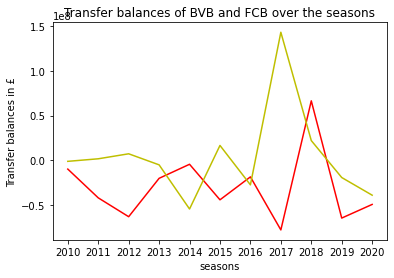

<Figure size 432x432 with 0 Axes>

In [35]:
plt.plot(seasons,FCB_balances, 'r')
plt.plot(seasons,BVB_balances, 'y')
plt.xticks(seasons)
plt.title('Transfer balances of BVB and FCB over the seasons')
plt.ylabel('Transfer balances in £')
plt.xlabel('seasons')
plt.figure(figsize=(6,6))
plt.show()

Interseting that BVB actually seems to make money from transfers while FCB on loses money from transers. It makes sense that staying on top and also having amibitons in the champions league requires a club to spend a lot,though.

I actually expected BVB to gain even more money from transfers when compared to FCB because BVB was and still is seen as a talent factory, with excellent scouting. Because of covid-19 the financials of teams certainly took a hit, so it might make sense to look at the development of market value for the different players in each team.

In [36]:
FCB_ages_avg=[]
BVB_ages_avg=[]

# calculation mean age of transfers for each year, where transfers > 0 to exclude loans for FCB
def age_fcb(year):
    df = fee_grp.get_group(('Bayern Munich','in',year))
    df = df[df.fee > 0]
    buy = df.age.mean()
   
    FCB_ages_avg.append(buy)
    return

# calculation mean age of transfers for each year, where transfers > 0 to exclude loans for BVB
def age_bvb(year):
    df = fee_grp.get_group(('Borussia Dortmund','in',year))
    df = df[df.fee > 0]
    buy = df.age.mean()
   
   
    BVB_ages_avg.append(buy)
    return

seasons = range(2010, 2021)
for year in seasons:
    age_fcb(year)
    age_bvb(year)

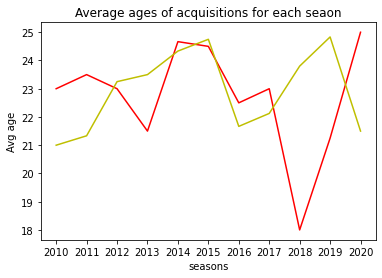

<Figure size 432x432 with 0 Axes>

In [37]:
plt.plot(seasons,FCB_ages_avg, 'r')
plt.plot(seasons,BVB_ages_avg, 'y')
plt.xticks(seasons)
plt.title('Average ages of acquisitions for each seaon')
plt.ylabel('Avg age')
plt.xlabel('seasons')
plt.figure(figsize=(6,6))
plt.show()

In the plot above I certainly expected BVB to aquire younger talent than FCB. As mentioned above they are known to be a talent factory, giving young talents chances to play and develop while FCB is obviously the strongest team with the highest internal competition, driving away young talents who just want to improve and get as much play time as possible.


Comparing the transfer policy for each teams has already resulted in some insights:

BVB is makeing more money from transfers than FCB, maybe even being content with being the number 2 and having the priority on making as much money as possible. FCB actually started spending more, even losing money on transfers after losing the season of 2011/12.

The Average ages of acquisitions for each seaon is pretty similiar, it might make sense to look at certain players and cases alone, because maybe BVB bought some older player as a safety subsitute etc.


# Conclusion

We can see that there are relationships and trends within the data which make this dataset viable for further exploration. There are plenty of questions still to be answered with EDA not even having touched the second player statistics dataframe.

Within the project it will be very interesting to use the two dataframes in conjunction and pay particular attention to some players. I hope to answer the quesions from the aims and goals rubric in the project.



# References


[1]	DFB. DEUTSCHE MEISTER Seit Einführung der Bundesliga. https://www.dfb.de/bundesliga/statistik/bisherige-meister/.


## Resources used : Webscraping

-	Webscraping lecture and lab, Data Programming, Sean McGrath

-	Human Code. 2019. Web scraping with Python using Requests and LXML - Crash course. https://youtu.be/JyIuMooTRFA

-	https://lxml.de/index.html#documentation

-	2018. Web Scraping using lxml and Python 2018: Extracting data from Steam. https://www.youtube.com/watch?v=5N066ISH8og


## Rosources used: Data cleaning and processing




-	DSM020-01 - Data Programming, lectures and labs, Sean McGrath

-	https://pandas.pydata.org/docs/index.html

-	Corey Schafer. Python Pandas Tutorial (Part 9): Cleaning Data - Casting Datatypes and Handling Missing Values.     https://www.youtube.com/watch?v=KdmPHEnPJPs

-	https://stackoverflow.com/questions/37428218/how-to-properly-apply-a-lambda-function-into-a-pandas-data-frame-column


## Rosources used: EDA


-	Lectures from several other modules as basic knowdlege

-	DSM020-01 - Data Programming, lectures and labs, Sean McGrath

-	stackoverflow.com

-	DataCamp. Python Tutorial: Plotting multiple graphs. https://youtu.be/-2AMr95nUDw